In [2]:
import sys
import geopandas as gpd
import pandas as pd
import xarray as xr
#import rasterio
import math
#from rasterstats import zonal_stats
import pycountry
import numpy as np
import pytz
from scipy.interpolate import interp1d
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

#sys.path.append('../data/automatic/when2heat/')
#from scripts import cop, read, preprocess, misc


sys.path.append('../src/construct/')
import util

population = '../land-eligibility/build/eurospores/population.csv'
population_tif = '../land-eligibility/build/population-europe.tif'
units = '/cluster/work/cpesm/brynmorp/euro-spores/land-eligibility/build/eurospores/units.geojson'
annual_demand = "../build/annual_heat_demand.csv"
dwellings = "../data/automatic/dwellings.tsv.gz"
model_year = 2016

EPSG_3035_PROJ4 = "+proj=laea +lat_0=52 +lon_0=10 +x_0=4321000 +y_0=3210000 +ellps=GRS80 +units=m +no_defs "
WGS84 = "EPSG:4326"

idx = pd.IndexSlice

In [3]:
def map_to_merra2(population, air_temp, units):
    # Get population per merra-2 site id and country
    europe_shape = gpd.read_file(units)
    if isinstance(europe_shape.crs, dict):
        europe_shape.crs = europe_shape.crs['init']  # {'init': '...'} is deprecated

    coords = air_temp[['lat', 'lon']].to_dataframe()

    points = gpd.GeoDataFrame(
        geometry=gpd.points_from_xy(coords.lon.values, coords.lat.values),
        index=coords.index, crs=WGS84
    )
    points_m = points.to_crs(EPSG_3035_PROJ4)
    polys_m = gpd.GeoDataFrame(
        index=points_m.index, geometry=points_m.buffer(25000).envelope  # 50km horizontal resolution
    )
    polys_eu = gpd.overlay(polys_m.to_crs(WGS84).reset_index(), europe_shape.to_crs(WGS84))

    with rasterio.open(population) as src:
        array = src.read(1)
        crs = src.crs
        affine = src.transform

        pop_polys = zonal_stats(polys_eu.to_crs(crs), array, affine=affine, stats='sum', nodata=0)
        polys_eu['population'] = [i['sum'] for i in pop_polys]

        pop_eu = zonal_stats(europe_shape.to_crs(crs), array, affine=affine, stats='sum', nodata=0)
        europe_shape['population'] = [i['sum'] for i in pop_eu]

    assert math.isclose(
        europe_shape.population.sum(), polys_eu.population.sum(), abs_tol=10**3
    )

    return polys_eu.set_index('site').drop(columns=['name', 'type', 'proper'])
mapped_pop = map_to_merra2(population_tif, xr.open_dataset('../data/weather/temperature.nc'), units)
mapped_pop['longitude'] = mapped_pop.centroid.x
mapped_pop['latitude'] = mapped_pop.centroid.y

In [4]:
def scale_national_annual_demand(mapped_pop, annual_demand, model_year):
    """
    Re-scale demand data normalised against national population according to
    population of considered spatial resolution
    """
    national_annual_demand_ratio = pd.read_csv(annual_demand, index_col=[0, 1]).fillna(0)
    population_df = mapped_pop.set_index(['id', 'country_code']).population.groupby(level=[0, 1]).sum()
    scaled_annual_demand = (
        national_annual_demand_ratio
        .xs(model_year, level='year')
        .align(population_df, axis=0, level='country_code')[0]
        .mul(population_df, axis=0)
        .reset_index('country_code', drop=True)
        .stack()
    )

    return scaled_annual_demand

scaled_annual_demand = scale_national_annual_demand(mapped_pop, annual_demand, model_year)

In [5]:
def prep_weather_data(filepath, variable, model_year, mapped_pop):
    _ds = xr.open_dataset(filepath).loc[{'time': str(model_year)}]
    _df = _ds[variable].to_pandas()
    _df = _df.loc[mapped_pop.index].assign(latitude=mapped_pop.latitude, longitude=mapped_pop.longitude, country=mapped_pop.id).set_index(['country', 'latitude', 'longitude'])
    _df.columns = pd.to_datetime(_df.columns)
    
    return _df.T

In [6]:
air_temp = (prep_weather_data('../data/weather/temperature.nc', 'temperature', model_year, mapped_pop) + 273.15)
soil_temp = (prep_weather_data('../data/weather/tsoil5.nc', 'soil_temperture_5', model_year, mapped_pop))
soil_temp = soil_temp.where(soil_temp > 0).dropna(axis=1)

In [7]:
temperature = pd.concat([air_temp, soil_temp], axis=1, keys=['air', 'soil'], names=['source'])

In [18]:
source_temperature = cop.source_temperature(temperature.rename_axis(columns={'source': 'parameter'}))
sink_temperature = cop.sink_temperature(temperature.rename_axis(columns={'source': 'parameter'}))

cop_parameters = read.cop_parameters('../data/automatic/when2heat/input')
spatial_cop = cop.spatial_cop(source_temperature, sink_temperature, cop_parameters).filter(regex='air|soil')
spatial_cop.rename(columns={'ground': 'soil', 'floor': 'underfloor', 'radiator': 'radiator_large'}, inplace=True)

In [8]:
site_pop = mapped_pop[['population', 'longitude', 'latitude']].set_index(['latitude', 'longitude']).population

In [125]:
# Staffell et al. data
def t_to_cop_staffell(x, sink_t=40):
    dt = sink_t + 273.15 - x
    if x.name[0] == 'air':
        dt = dt.clip(lower=15, upper=60)
        cop = 6.81 - 0.121 * dt + 0.000630 * dt ** 2
    elif x.name[0] == 'soil':
        dt = dt.clip(lower=20, upper=60)
        cop = 8.77 - 0.15 * dt + 0.000734 * dt ** 2
    return cop


# When2Heat data
def t_to_cop_when2heat(x, sink_t=40):
    if x.name[0] == 'air':
        dt = sink_t + 273.15 - x
        dt = dt.clip(lower=15, upper=60)
        cop = 6.0801 - 0.0941 * dt + 0.0005 * dt ** 2
    elif x.name[0] == 'soil':
        dt = sink_t + 273.15 - (x - 5)  # remove 5K from the data to go from soil to brine
        dt = dt.clip(lower=20, upper=60)
        cop = 10.288 - 0.2084 * dt + 0.0012 * dt ** 2
    return cop.mul(0.85)  # correction factor of 0.85 to go to 'real' system


# Nouvel data
def t_to_cop_nouvel(x, sink_t=40):
    sink_t = sink_t + 273.15
    dt = sink_t - x
    cop = 0.36 * sink_t / dt
    return cop


# WAMAK data
hp_data = pd.read_csv('../data/automatic/wamak_hp_data.csv', index_col=0, header=[0, 1, 2, 3])
hp_data = hp_data.rename_axis(columns={'ºC': 'sink_temp', 'Source': 'data_type'})
hp_data.columns = hp_data.columns.set_levels(hp_data.columns.levels[-1].astype(int), level='sink_temp')

hp_cop_data = (
    hp_data.xs('COP', level='data_type', axis=1)
    .groupby(level=['source', 'sink_temp'], axis=1)
    .mean()
)
def t_to_cop_wamak(x, sink_t=40):
    x = x - 273.15
    if x.name[0] == 'air':
        _data = hp_cop_data.xs('air', level='source', axis=1)
        source_t = x
        
    elif x.name[0] == 'soil':
        _data = hp_cop_data.xs('ground', level='source', axis=1)
        source_t = x - 5
        
    _sink_data = interp1d(
        _data.columns, 
        _data.values, 
        fill_value="extrapolate"
    )(sink_t)
    cop = interp1d(
        _data.dropna().index, 
        _sink_data[~np.isnan(_sink_data)], 
        fill_value="extrapolate"
    )(source_t)        

    return cop * 0.85  # correction factor of 0.85 to go to 'real' system

In [126]:
temperature_simple = pd.DataFrame(
    data=np.array([np.linspace(-25, 25, 50), np.linspace(-5, 20, 50)]).T, 
    columns=pd.MultiIndex.from_tuples([('air',), ('soil',)], names=['source'])
) + 273.15
sink_ts = {'underfloor': 35, 'radiator_large': 50, 'radiator_conventional': 65, 'water': 60}
methods = {
    'wamak': t_to_cop_wamak, 
    'staffell': t_to_cop_staffell, 
    'nouvel': t_to_cop_nouvel, 
    'when2heat': t_to_cop_when2heat
}
cop_data = pd.concat(
    [pd.concat(
        [temperature_simple.apply(method_func, sink_t=v) for v in sink_ts.values()],
        keys=list(sink_ts.keys()), names=['sink'], axis=1
    ) for method_func in methods.values()],
    keys=list(methods.keys()), names=['method'], axis=1
).stack([0, 1, 2]).to_frame('cop')
cop_data['temperature'] = (
    temperature_simple.stack().stack()
    .reset_index(level=1, drop=True)
    .loc[cop_data.reset_index([1, 2], drop=True).index]
    .values - 273.15
)
cop_data = cop_data.reset_index(0, drop=True)

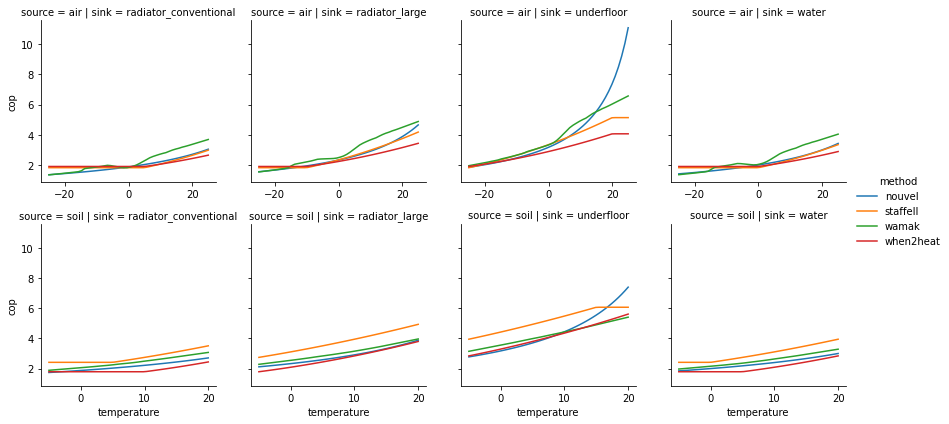

In [127]:
g = sns.FacetGrid(cop_data.reset_index(), row='source', col='sink', hue='method', sharex=False)
g.map(sns.lineplot, 'temperature', 'cop')
g.add_legend()

In [128]:
sink_ts = {'underfloor': 35, 'radiator_large': 50, 'radiator_conventional': 65, 'water': 60}
spatial_cop_staffell = pd.concat(
    [temperature.apply(t_to_cop_staffell, sink_t=v) for v in sink_ts.values()],
    keys=list(sink_ts.keys()), names=['sink'], axis=1
)

spatial_cop_when2heat = pd.concat(
    [temperature.apply(t_to_cop_when2heat, sink_t=v) for v in sink_ts.values()],
    keys=list(sink_ts.keys()), names=['sink'], axis=1
)

spatial_cop_nouvel = pd.concat(
    [temperature.apply(t_to_cop_nouvel, sink_t=v) for v in sink_ts.values()],
    keys=list(sink_ts.keys()), names=['sink'], axis=1
)

spatial_cop_wamak = pd.concat(
    [temperature.apply(t_to_cop_wamak, sink_t=v) for v in sink_ts.values()],
    keys=list(sink_ts.keys()), names=['sink'], axis=1
)

In [34]:
_hp_data.unstack()

source  product              data_type         sink_temp  source_temp
air     AW 30 EVI            Heating capacity  35         -20            19.58
                                                          -19            19.98
                                                          -18            20.37
                                                          -17            20.77
                                                          -16            21.17
                                                                         ...  
ground  TBW 98 EVI HD Modul  COP               65          16              NaN
                                                           17              NaN
                                                           18              NaN
                                                           19              NaN
                                                           20              NaN
Length: 34809, dtype: float64

In [43]:
def cap_to_cap_ratio(x):
    if x.name == 'air':
        return x / x.xs((2, 35), level=('source_temp', 'sink_temp'))
    elif x.name == 'ground':
        return x / x.xs((0, 35), level=('source_temp', 'sink_temp'))

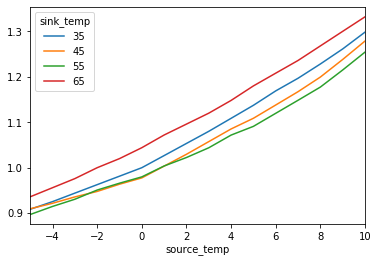

In [47]:
_df = (
        _hp_data.unstack().xs('Heating capacity', level='data_type')
        .unstack('source')
        .apply(cap_to_cap_ratio, axis=0)
        .stack()
        .groupby(level=['source', 'source_temp', 'sink_temp'])  # average of all products
        .mean()
        .dropna()
    )
_df.xs('ground').unstack().plot()

In [129]:
def wavg(x):
    to_drop = [i for i in x.columns.names if i not in ['latitude', 'longitude']]
    weighted_avg = np.average(x, weights=site_pop.reindex(x.droplevel(to_drop, axis=1).columns).fillna(0), axis=1)
    return pd.Series(data=weighted_avg, index=x.index)

def shift_profiles(x):
    model_year = x.index.year.unique().item()
    country = pycountry.countries.lookup(x.name[0].split('_')[0]).alpha_2
    tz = pytz.country_timezones[country][0]
    try:
        idx = x.index.tz_localize(tz, nonexistent='shift_forward').tz_convert('UTC')
    except pytz.AmbiguousTimeError as err:
        idx = x.index.tz_localize(tz, ambiguous=x.index != err.args[0], nonexistent='shift_forward').tz_convert('UTC')
    shift = len(idx[idx.year > model_year]) - len(idx[idx.year < model_year])

    x = pd.Series(data=np.roll(x, shift=shift), index=x.index)
    
    return x


regional_cop = spatial_cop.dropna(axis=1).groupby(level=['country', 'sink', 'source'], axis=1).apply(wavg).mul(0.85)
regional_cop_when2heat = spatial_cop_when2heat.dropna(axis=1).groupby(level=['country', 'sink', 'source'], axis=1).apply(wavg)
regional_cop_staffell = spatial_cop_staffell.dropna(axis=1).groupby(level=['country', 'sink', 'source'], axis=1).apply(wavg)
regional_cop_nouvel = spatial_cop_nouvel.dropna(axis=1).groupby(level=['country', 'sink', 'source'], axis=1).apply(wavg)
regional_cop_wamak = spatial_cop_wamak.dropna(axis=1).groupby(level=['country', 'sink', 'source'], axis=1).apply(wavg)

regional_temperature = (temperature - 273.15).dropna(axis=1).groupby(level=['country', 'source'], axis=1).apply(wavg)


In [45]:
space_demand = pd.read_csv('../build/model/eurospores/space-heat-demand.csv', index_col=0, parse_dates=True)
water_demand = pd.read_csv('../build/model/eurospores/water-heat-demand.csv', index_col=0, parse_dates=True)

In [178]:
def get_spfs(cop_source):
    heat_v_temp = pd.concat([
        regional_temperature.xs('air', level='source', axis=1).stack(),
        space_demand.apply(lambda x: x / x.sum(), axis=0).stack(),  # normalise relative total regional demand
        water_demand.apply(lambda x: x / x.sum(), axis=0).stack()  # normalise relative total regional demand
    ], axis=1, keys=['air_temperature', 'space_heat', 'water_heat'], sort=True)
    for sink in ['underfloor', 'radiator_conventional', 'radiator_large']:
        heat_v_temp[f'air_space_{sink}_cop'] = (
            cop_source
            .xs(('air', sink), level=('source', 'sink'), axis=1)
            .stack()
            .reindex(heat_v_temp.index)
        )
        heat_v_temp[f'ground_space_{sink}_cop'] = (
            cop_source
            .xs(('soil', sink), level=('source', 'sink'), axis=1)
            .stack()
            .reindex(heat_v_temp.index)
        )
    heat_v_temp['air_water_cop'] = (
        cop_source
        .xs(('air', 'water'), level=('source', 'sink'), axis=1)
        .stack()
        .reindex(heat_v_temp.index)
    )
    heat_v_temp['ground_water_cop'] = (
        cop_source
        .xs(('soil', 'water'), level=('source', 'sink'), axis=1)
        .stack()
        .reindex(heat_v_temp.index)
    )
    heat_v_temp = heat_v_temp.dropna()
    
    spfs = pd.concat(
        [heat_v_temp
         .groupby(level=1)
         .apply(lambda x: np.average(x[f'{i}_{j}_cop'], weights=x['{}_heat'.format(j.split('_')[0])]))
         for i in ['air', 'ground'] 
         for j in ['space_underfloor', 'space_radiator_conventional', 
                   'space_radiator_large','water']],
        keys=[f'{i}_{j}' 
              for i in ['air', 'ground'] 
              for j in ['space_underfloor', 'space_radiator_conventional', 
                        'space_radiator_large','water']], axis=1
    )
    return heat_v_temp, spfs

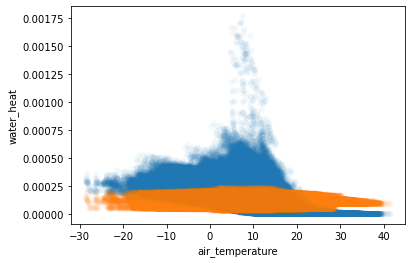

In [90]:
sns.scatterplot(data=heat_v_temp, x='air_temperature', y='space_heat', ec='None', alpha=0.05)
sns.scatterplot(data=heat_v_temp, x='air_temperature', y='water_heat', ec='None', alpha=0.05)

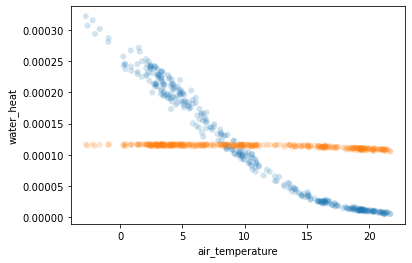

In [91]:
heat_v_temp_1d = heat_v_temp.resample('1D', level=0).mean()
sns.scatterplot(data = heat_v_temp_1d, x='air_temperature', y='space_heat', ec='None', alpha=0.2)
sns.scatterplot(data = heat_v_temp_1d, x='air_temperature', y='water_heat', ec='None', alpha=0.2)

In [147]:
units_gdf = gpd.read_file(units).set_index('id')

In [179]:
methods = {
    'wamak': regional_cop_wamak, 
    'staffell': regional_cop_staffell, 
    'nouvel': regional_cop_nouvel, 
    'when2heat': regional_cop_when2heat
}
spfs = pd.concat(
    [get_spfs(i)[1] for i in methods.values()],
    keys=methods.keys(), axis=1
)

In [180]:
spfs

wamak                                  \
      air_space_underfloor air_space_radiator_conventional   
ALB_1             4.534275                        2.525540   
AUT_1             3.668319                        2.117214   
AUT_2             3.821854                        2.165563   
AUT_3             3.846389                        2.178693   
BEL_1             4.101017                        2.283054   
...                    ...                             ...   
SVN_1             3.940738                        2.221299   
SWE_1             3.225743                        1.965891   
SWE_2             3.430029                        2.023673   
SWE_3             3.684191                        2.108395   
SWE_4             3.868433                        2.172683   

                                                                  \
      air_space_radiator_large air_water ground_space_underfloor   
ALB_1                 3.383877  3.295042                4.712636   
AUT_1                 2.785968  2.647491                3.988100   
AUT_2                 2.878628  2.820009                4.201957   
AUT_3                 2.896201  2.915497                4.346650   
BEL_1                 3.062056  2.943574                4.396135   
...                        ...       ...                     ...   
SVN_1                 2.960306  2.935450                4.310124   
SWE_1                 2.503490  2.478090                3.821930   
SWE_2                 2.627974  2.555229                3.903133   
SWE_3                 2.785374  2.740714                4.106760   
SWE_4                 2.900965  2.829608                4.197996   

                                                                      \
      ground_space_radiator_conventional ground_space_radiator_large   
ALB_1                           2.659247                    3.384309   
AUT_1                           2.255413                    2.839941   
AUT_2                           2.366374                    2.991763   
AUT_3                           2.447179                    3.098631   
BEL_1                           2.471897                    3.132630   
...                                  ...                         ...   
SVN_1                           2.426484                    3.071707   
SWE_1                           2.175753                    2.724922   
SWE_2                           2.214301                    2.780914   
SWE_3                           2.315928                    2.923433   
SWE_4                           2.363267                    2.988355   

                               staffell                                  ...  \
      ground_water air_space_underfloor air_space_radiator_conventional  ...   
ALB_1     2.863694             3.995604                        2.021887  ...   
AUT_1     2.385673             3.468364                        1.884039  ...   
AUT_2     2.523651             3.582197                        1.898314  ...   
AUT_3     2.617420             3.594768                        1.896654  ...   
BEL_1     2.641953             3.750868                        1.909207  ...   
...            ...                  ...                             ...  ...   
SVN_1     2.596323             3.654032                        1.912263  ...   
SWE_1     2.297742             3.099893                        1.856068  ...   
SWE_2     2.340291             3.284874                        1.864595  ...   
SWE_3     2.465459             3.479738                        1.874767  ...   
SWE_4     2.527649             3.615048                        1.877676  ...   

                           nouvel                         when2heat  \
      ground_space_radiator_large ground_water air_space_underfloor   
ALB_1                    3.162938     2.598910             3.314353   
AUT_1                    2.595576     2.199122             2.969291   
AUT_2                    2.745358     2.312106             3.043640

In [188]:
methods.keys()

dict_keys(['wamak', 'staffell', 'nouvel', 'when2heat'])

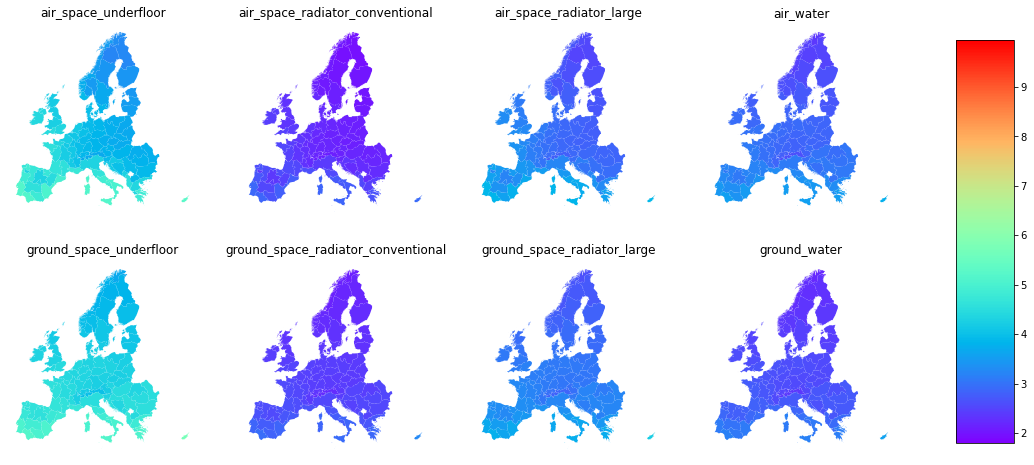

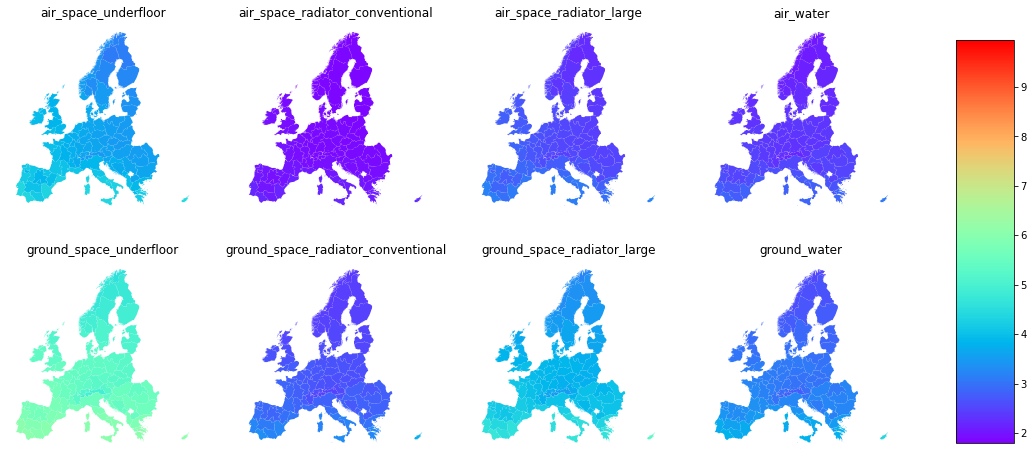

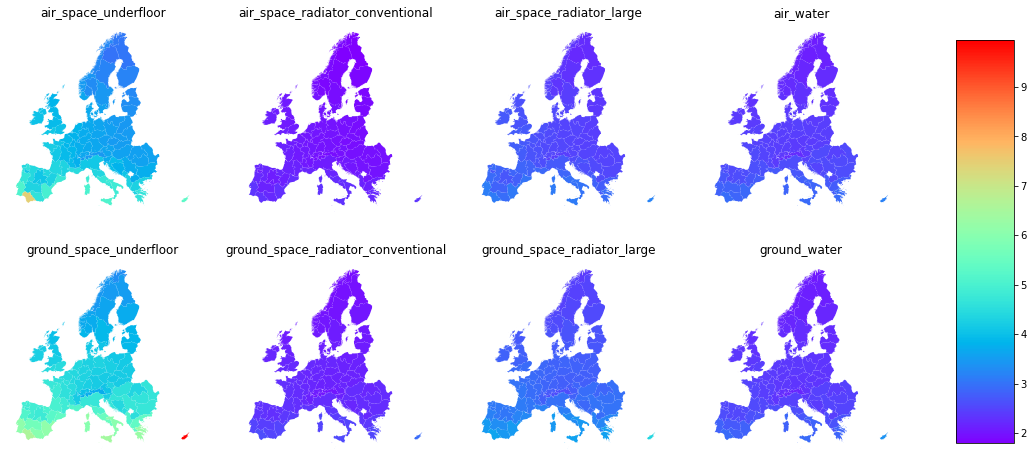

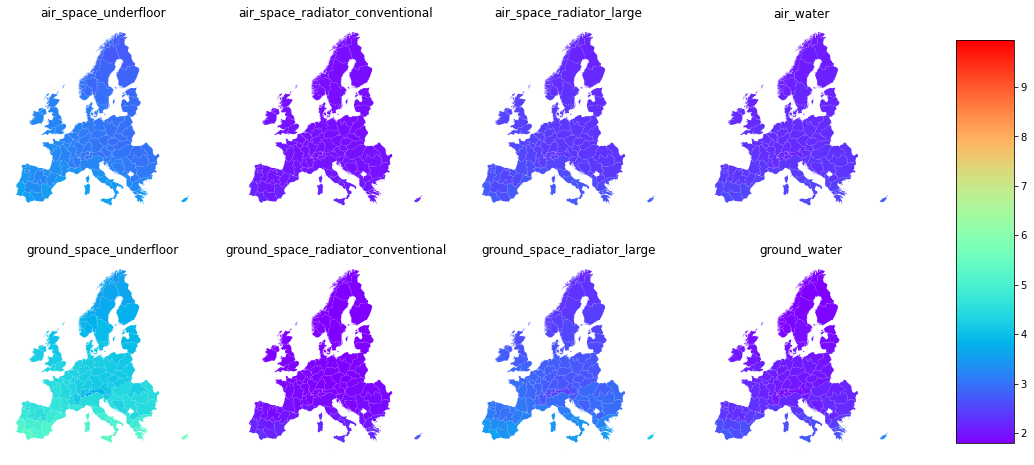

In [187]:
units_gdf = units_gdf.to_crs('EPSG:3035')
for k in methods.keys():
    foo = units_gdf.join(spfs.xs(k, axis=1))
    fig, ax = plt.subplots(2, 4, figsize=(16, 8), frameon=False)
    _ax = 0


    cmap = mpl.cm.rainbow
    norm = mpl.colors.Normalize(vmin=spfs.min().min(), vmax=spfs.max().max())
    mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
    fig.subplots_adjust(right=0.9)
    cbar_ax = fig.add_axes([0.95, 0.15, 0.05, 0.7])

    for i in ['air', 'ground']:
        _ax1 = 0
        for j in [
            'space_underfloor', 'space_radiator_conventional', 
            'space_radiator_large','water'
        ]:
            foo.plot(
                f'{i}_{j}', 
                ax=ax[_ax, _ax1], 
                vmin=spfs.min().min(), 
                vmax=spfs.max().max(),
                cmap=cmap
            )
            ax[_ax, _ax1].set_title(f'{i}_{j}')
            ax[_ax, _ax1].axis('off')
            _ax1 += 1
        _ax += 1
    fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cbar_ax)

# Get heat pump data direct from manufacturer

In [3]:
# Get WAMAK heat pump data
heat_pumps = {
    'air': {
        'WA001045': 'AW 30 EVI',
        'WA001046': 'AW 40 EVI',
        'WA001047': 'AW 47 EVI',
        'WA001245': 'AWK 30 EVI',
        'WA001246': 'AWK 40 EVI',
        'WA001247': 'AWK 47 EVI',
        'WA001342': 'AiWa 08 EVI S',
        'WA001343': 'AiWa 11 EVI S',
        'WA001344': 'AiWa 14 EVI S',
        'WA001345': 'AiWa 18 EVI S',
        'WA001346': 'AW 23 EVI',
        'WA001347': 'AW 27 EVI',
        'WA001348': 'AW 35 EVI',
        'WA001349': 'AW 40 EVI',
        'WA001350': 'AW 47 EVI',
        'WA001447': 'AWK 27 EVI',
        'WA001448': 'AWK 35 EVI',
        'WA001449': 'AWK 40 EVI',
        'WA001450': 'AWK 47 EVI',
        'WA001491': 'AiWa 05 EVI Block',
        'WA001492': 'AiWa 08 EVI Block',
        'WA001493': 'AiWa 11 EVI Block',
        'WA0e1251': 'AiWa 08 H Out',
        'WA0e1252': 'AiWa 12 H Out',
        'WA0e1352': 'AiWa 08 EVI H Out',
        'WA0e1353': 'AiWa 11 EVI H Out',
        'WA0e1354': 'AiWa 14 EVI H Out',
        'WA0e1355': 'AiWa 18 EVI H Out',
        'WA0e1356': 'AiWa 23 EVI H Out',
        'WA0e1357': 'AiWa 23 EVI H-Twin Out',
        'WA0i1251': 'AiWa 08 H In',
        'WA0i1252': 'AiWa 12 H In',
        'WA0i1352': 'AiWa 08 EVI H In',
        'WA0i1353': 'AiWa 11 EVI H In',
        'WA0i1354': 'AiWa 14 EVI H In',
        'WA0L1352': 'AiWa 08 EVI L',
        'WA0L1353': 'AiWa 11 EVI L',
        'WA0L1354': 'AiWa 14 EVI L',
        'WAHD1143': 'AW 65 EVI HD',
        'WAHD1144': 'AW 95 EVI HD',
        'WAHD1145': 'AW 140 EVI HD',
        'WAi01042': 'AiWa 16i EVI S VarioSONIC',
        'WAie1261': 'AiWa 08i EVI H Out',
        'WAie1262': 'AiWa 16i EVI H Out VarioSONIC',
        'WAii1261': 'AiWa 08i EVI H In',
        'WAii1262': 'AiWa 16i EVI H In VarioSONIC',
        'WAiL1262': 'AiWa 16i EVI L VarioSONIC'
    },
    'ground': {
        'WA001012': 'BW 05',
        'WA001013': 'BW 08',
        'WA001014': 'BW 10',
        'WA001015': 'BW 13',
        'WA001016': 'BW 17',
        'WA001017': 'BW 21',
        'WA001072': 'BW 05 Block',
        'WA001073': 'BW 08 Block',
        'WA001074': 'BW 10 Block',
        'WA001162': 'TBW 27',
        'WA001163': 'TBW 36',
        'WA001164': 'TBW 50',
        'WA001166': 'TBW 66',
        'WA001168': 'TBW 90',
        'WA001310': 'BW 06 EVI',
        'WA001311': 'BW 09 EVI',
        'WA001312': 'BW 11 EVI',
        'WA001313': 'BW 14 EVI',
        'WA001314': 'BW 19 EVI',
        'WA001315': 'BW 24 EVI',
        'WA001316': 'BW 27 EVI',
        'WA001317': 'BW 36 EVI',
        'WA001318': 'BW 42 EVI',
        'WA001319': 'BW 49 EVI',
        'WA001351': 'TBW 22 EVI',
        'WA001352': 'TBW 28 EVI',
        'WA001353': 'TBW 38 EVI',
        'WA001354': 'TBW 50 EVI',
        'WA001355': 'TBW 73 EVI',
        'WA001356': 'TBW 85 EVI',
        'WA001357': 'TBW 98 EVI',
        'WAMBW112': 'BW 112 HD Modul',
        'WAMBW49I': 'BW 49 EVI HD Modul',
        'WAMOBW42': 'BW 42 HD Modul',
        'WAMOBW54': 'BW 54 HD Modul',
        'WAMOBW68': 'BW 68 HD Modul',
        'WAMOBW88': 'BW 88 HD Modul',
        'WAMTB176': 'TBW 176 HD Modul',
        'WAMTB224': 'TBW 225 HD Modul',
        'WAMTB98I': 'TBW 98 EVI HD Modul'
    }
}
hp_data = {}
for source, hps in heat_pumps.items():
    src = 'A' if source == 'air' else 'B'
    hp_data[source] = {}
    for hp_code, hp in hps.items():
         
        _data = pd.read_html(
            f'https://www.wamak.eu/wapps/datasheets/v2018/datasheet.php?standard=1&fsource={src}&code={hp_code}&lang=en-GB',
            index_col=0, header=[0, 1], match='Heating capacity'
        )
        cap = _data[0].loc['Input'].values.item().split(' kW')[0]
        try:
            float(cap)
            _performance = _data[-1].astype(float).div(100)
            _performance.columns.set_levels(
                levels=[_performance.columns.levels[0].str.split(' /', expand=True).levels[0], 
                        _performance.columns.levels[1].astype(int)], 
                level=[0, 1], inplace=True
            )
            hp_data[source][hp] = _performance
        except ValueError:
            print(f'Ignoring {hp} as it is a variable power HP')

Ignoring AiWa 16i EVI S VarioSONIC as it is a variable power HP
Ignoring AiWa 08i EVI H Out as it is a variable power HP
Ignoring AiWa 16i EVI H Out VarioSONIC as it is a variable power HP
Ignoring AiWa 08i EVI H In as it is a variable power HP
Ignoring AiWa 16i EVI H In VarioSONIC as it is a variable power HP
Ignoring AiWa 16i EVI L VarioSONIC as it is a variable power HP


In [4]:
hp_data = pd.concat(
    [pd.concat(hp_data['air'].values(), names=['product'], keys=hp_data['air'].keys(), axis=1),
     pd.concat(hp_data['ground'].values(), names=['product'], keys=hp_data['ground'].keys(), axis=1)],
    names=['source'], keys=['air', 'ground'], sort=True, axis=1
)

In [5]:
_hp_data = hp_data.rename_axis(columns={'ºC': 'sink_temp', 'Source': 'data_type'}, index='source_temp')
_hp_data.columns = _hp_data.columns.set_levels(_hp_data.columns.levels[-1].astype(int), level='sink_temp')
_hp_data.unstack().to_csv('../data/heat_pump_characteristics.csv', header=True)

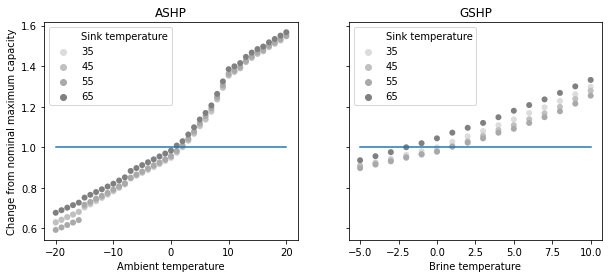

In [234]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

foo = hp_data.xs(('air', 'Heating capacity'), level=('source', 'data_type'), axis=1)
bar = (
    foo
    .apply(lambda x: x / foo.xs(35, level='sink_temp', axis=1).loc[2], axis=1)
    .mean(level='sink_temp', axis=1)
    .stack()
    .reset_index()
)
bar = bar.rename(columns={
    'level_0': 'Ambient temperature', 0: 'Change from nominal maximum capacity',
    'sink_temp': 'Sink temperature'
})
sns.scatterplot(
    data=bar, x='Ambient temperature', 
    y='Change from nominal maximum capacity', hue='Sink temperature', 
    ec='None', palette=['gainsboro', 'silver', 'darkgray', 'gray'],
    ax=ax[0]
)
ax[0].set_title('ASHP')
ax[0].add_line(mpl.lines.Line2D((-20, 20), (1, 1)))

foo = hp_data.xs(('ground', 'Heating capacity'), level=('source', 'data_type'), axis=1)
bar = (
    foo
    .apply(lambda x: x / foo.xs(35, level='sink_temp', axis=1).loc[0], axis=1)
    .mean(level='sink_temp', axis=1)
    .stack()
    .reset_index()
)
bar = bar.rename(columns={
    'level_0': 'Brine temperature', 0: 'Change from nominal maximum capacity',
    'sink_temp': 'Sink temperature'
})
sns.scatterplot(
    data=bar, x='Brine temperature', 
    y='Change from nominal maximum capacity', hue='Sink temperature', 
    ec='None', palette=['gainsboro', 'silver', 'darkgray', 'gray'],
    ax=ax[1]
)
ax[1].set_title('GSHP')
ax[1].add_line(mpl.lines.Line2D((-5, 10), (1, 1)))
ax[1].legend.

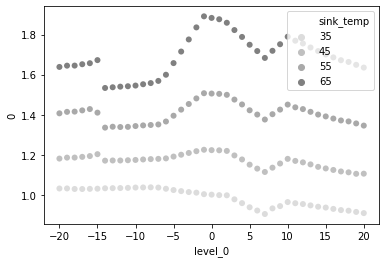

In [222]:
foo = hp_data.xs(('air', 'Power input'), level=('source', 'data_type'), axis=1)
bar = (
    foo
    .apply(lambda x: x / foo.xs(35, level='sink_temp', axis=1).loc[2], axis=1)
    .mean(level='sink_temp', axis=1)
    .stack()
    .reset_index()
)
bar['sink_temp'] = bar.sink_temp.astype(str)
sns.scatterplot(data=bar, x='level_0', y=0, hue='sink_temp', ec='None', palette=['gainsboro', 'silver', 'darkgray', 'gray'])

In [217]:
bar.sink_temp.unique()

array(['35', '45', '55', '65'], dtype=object)

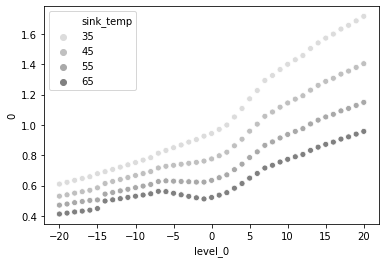

In [225]:
foo = (
    hp_data.xs(('air', 'Heating capacity'), level=('source', 'data_type'), axis=1).div(
    hp_data.xs(('air', 'Power input'), level=('source', 'data_type'), axis=1), axis=1
    )
)
bar = (
    foo
    .apply(lambda x: x / foo.xs(35, level='sink_temp', axis=1).loc[2], axis=1)
    .mean(level='sink_temp', axis=1)
    .stack()
    .reset_index()
)
sns.scatterplot(data=bar, x='level_0', y=0, hue='sink_temp', palette=['gainsboro', 'silver', 'darkgray', 'gray'])